In [1]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
faceEmotion_df= pd.read_csv("/content/drive/My Drive/Face Expression/fer2013.csv")

In [3]:
faceEmotion_df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
faceEmotion_df["emotion"][2]

2

In [5]:
type(faceEmotion_df["pixels"][2])

str

In [6]:
def stringToArray(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [7]:
faceEmotion_df["pixels"] = faceEmotion_df["pixels"].apply(lambda x: stringToArray(x))

In [8]:

faceEmotion_df["pixels"][2].shape


(48, 48, 1)

In [9]:
faceEmotion_df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [10]:
label_to_text = {0: "Anger", 1:"Disgust", 2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}

# Visualize Data


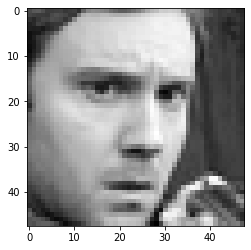

In [11]:
plt.imshow(faceEmotion_df["pixels"][0].squeeze(),cmap='gray')

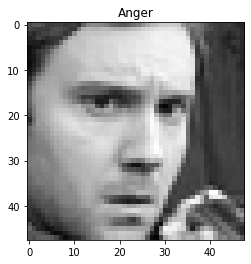

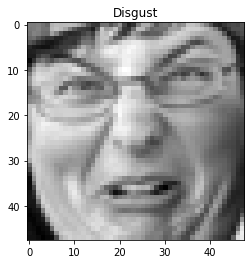

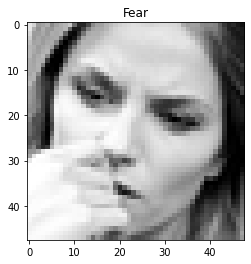

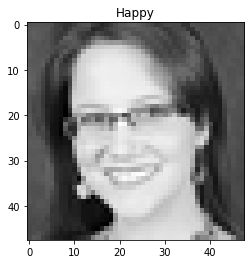

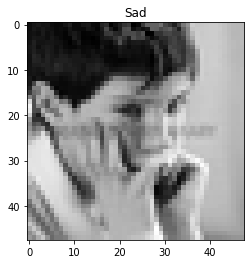

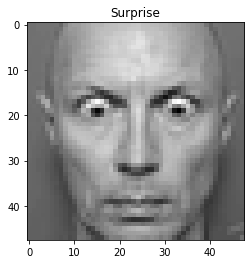

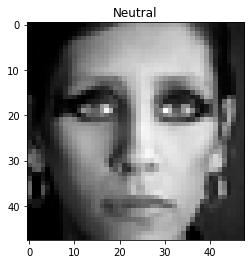

In [12]:
emotions = [0,1,2,3,4,5,6]

for i in emotions:
  data = faceEmotion_df[faceEmotion_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap= 'gray')

# Dataset balanced?
# Lets check it out using bar graph

Text(0.5, 1.0, 'Number of Sample per expression')

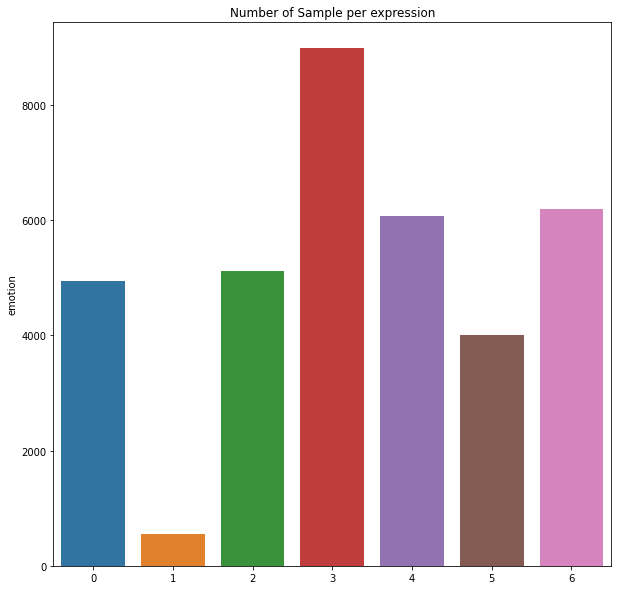

In [13]:
plt.figure(figsize=(10,10))

sns.barplot(x= faceEmotion_df.emotion.value_counts().index, y= faceEmotion_df.emotion.value_counts())
plt.title("Number of Sample per expression")

In [14]:
X= faceEmotion_df["pixels"]
X.shape

(35887,)

In [15]:
X= faceEmotion_df["pixels"]
y=pd.get_dummies(faceEmotion_df['emotion']) #one hot
X =np.stack(X,axis=0)
X=X.reshape(len(X),48,48,1)
X.shape

(35887, 48, 48, 1)

In [16]:
y.shape

(35887, 7)

In [17]:
y[0:]

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
35882,0,0,0,0,0,0,1
35883,0,0,0,1,0,0,0
35884,1,0,0,0,0,0,0
35885,0,0,0,1,0,0,0


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_Test,y_train,y_test = train_test_split( X, y, test_size= 0.1,shuffle=True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_test,test_size=0.5,shuffle=True)

In [22]:
X_Test.shape

(1795, 48, 48, 1)

In [28]:

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255


array([[[[1.7993080e-03],
         [1.9223376e-03],
         [1.9530950e-03],
         ...,
         [2.4452135e-03],
         [2.7527874e-03],
         [2.5990005e-03]],

        [[1.9069589e-03],
         [1.9223376e-03],
         [1.9684739e-03],
         ...,
         [2.0761248e-03],
         [1.6147635e-03],
         [2.0761248e-03]],

        [[1.9377163e-03],
         [1.8915802e-03],
         [1.9992313e-03],
         ...,
         [2.0915035e-03],
         [1.6762784e-03],
         [1.2918109e-03]],

        ...,

        [[1.7070358e-03],
         [2.3068052e-03],
         [2.2452904e-03],
         ...,
         [3.5524799e-03],
         [3.4602077e-03],
         [3.3833142e-03]],

        [[9.8423695e-04],
         [1.6608997e-03],
         [2.3221839e-03],
         ...,
         [3.5678586e-03],
         [3.4909651e-03],
         [3.4448290e-03]],

        [[1.1072665e-03],
         [1.0149943e-03],
         [1.5686274e-03],
         ...,
         [3.5832373e-03],
        

In [26]:
train_datagen = ImageDataGenerator(
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    fill_mode = "nearest",
                                    horizontal_flip =True,
                                   )

# Lets build a RESNET

In [58]:
def res_block(X, filter, stage):
  X_copy =X
  f1,f2,f3 = filter

  X = Conv2D(f1,(1,1), strides=(1,1),name = "res_"+str(stage)+"_conv_a")(X)
  X= MaxPool2D((2,2))(X)
  X = BatchNormalization(axis=3, name ="bn_"+str(stage)+"_conv_a")(X)
  X = Activation('relu')(X)

  X = Conv2D(f1,(3,3), strides=(1,1),padding="same",name = "res_"+str(stage)+"_conv_b")(X)
  X = BatchNormalization(axis=3, name ="bn_"+str(stage)+"_conv_b")(X)
  X = Activation('relu')(X)


  X = Conv2D(f3,kernel_size=(1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_c')(X)
  X =BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_c')(X)

  #now lets make X_copy and X same size so that we can add them
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy')(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  X = Add()([X,X_copy])
  X=Activation('relu')(X)

  X_copy =X

  X = Conv2D(f1, (1,1), strides=(1,1),name="res_"+str(stage)+"_identity_1_a")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_1_a')(X)
  X = Activation("relu")(X)

  
  X = Conv2D(f2, (3,3), strides=(1,1),padding="same",name="res_"+str(stage)+"_identity_1_b")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_1_b')(X)
  X = Activation("relu")(X)

  
  X = Conv2D(f3, (1,1), strides=(1,1),name="res_"+str(stage)+"_identity_1_c")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_1_c')(X)

  X = Add()([X,X_copy])
  X=Activation("relu")(X)

  X_copy =X


  X = Conv2D(f1, (1,1), strides=(1,1),name="res_"+str(stage)+"_identity_2_a")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_2_a')(X)
  X = Activation("relu")(X)


  X = Conv2D(f2, (3,3), strides=(1,1),padding="same",name="res_"+str(stage)+"_identity_2_b")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_2_b')(X)
  X = Activation("relu")(X)


  X = Conv2D(f3, (1,1), strides=(1,1),name="res_"+str(stage)+"_identity_2_c")(X)
  X = BatchNormalization(axis =3, name ="bn_"+str(stage)+'_identity_2_c')(X)


  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X





In [59]:
input_shape = (48,48,1)

X_input= Input(input_shape)

X =ZeroPadding2D((3,3))(X_input)
#1 Stage
X = Conv2D(64,(7,7),strides=(2,2),name="conv1")(X)
X= BatchNormalization(axis=3,name="bn_conv1")(X)
X = Activation('relu')(X)
X= MaxPool2D((3,3),strides=(2,2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)


# 4 - stage
X = res_block(X, filter= [256, 256, 1024], stage= 4)

X = Flatten()(X)
X = Dense(512, activation = 'relu', name = 'Dense_1st')(X)
X= Dense(128, activation='relu', name="Dense_2nd")(X)
X= Dense(7,activation="softmax", name="Dense_Final")(X)


model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 54, 54, 1)    0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________